# Divergent Image

The idea here is to get the most similar images based on the text similarity between the caption generated by trained deep learning model for the input image and the list of captions for the images stored. The text similarity score lies between 0 to 1.The images are selected whose similarity score is above or equal to 0.90.

In [1]:
import numpy as np #to perform computations
from PIL import Image #to load image files
import matplotlib.pyplot as plt #to display image
from pickle import load,dump #to load or dump files
from keras.models import Model, load_model #to load available models
from keras.applications.xception import Xception,preprocess_input #to preprocess image file
from keras.preprocessing.sequence import pad_sequences
import spacy #to calculate text similarity
import itertools #to slice dictionary
from nltk.translate.bleu_score import corpus_bleu #to evaluate generated captions
%matplotlib inline

### Reading cleared caption file

In [2]:
def input_Texts():
    file1 = open("Data/Flickr8k_text/Captions.txt","r")
    captions = file1.readlines()
    data = {lines.split("\t")[0].split("#")[0].strip("\'"):lines.split("\t")[1].rstrip().strip("\'") for lines in captions}
    return data

### Function to generate text caption for a given image

In [3]:
def generate_Description(trained_Model,xception_Model,maximum_Length,img_path,inverse_vocab,tokenizer):
    test_image = Image.open(img_path)
    test_image = test_image.resize((299,299))
    test_image = np.array(test_image)
    if test_image.shape[2] == 4:
        test_image = test_image[..., :3]
    test_image = np.expand_dims(test_image, axis=0)
    test_image = test_image/127.5 #Normalizing
    test_image = test_image - 1.0 #Scaling
    features = xception_Model.predict(test_image)
    start_text = "start"
    for i in range(maximum_Length):
        sequence = tokenizer.texts_to_sequences([start_text])[0]
        sequence = pad_sequences([sequence], maxlen=maximum_Length)
        pred = trained_Model.predict([features,sequence], verbose=0)
        pred = np.argmax(pred)
        word = inverse_vocab[pred]
        if(word is None):
            break
        start_text+= ' '+ word
        if(word == 'end'):
            break
    return start_text

In [4]:
max_length = 33 #Maximum length of sentences
tokenized_text = load(open("Data/Flickr8k_text/tokenized_text.p","rb")) #Loading vocabulary
model = load_model('Models/Finalized_Model/model-ep003-loss3.414-val_loss3.621.h5') # Loading trained model
xception = Xception(include_top=False, pooling="avg") #to extract features for the input test images

#generating inverse vocabulary
vocab = {index:word for word,index in tokenized_text.word_index.items()}

In [5]:
image_file = "Data/Flicker8k_Dataset/3325974730_3ee192e4ff.jpg"
caption = generate_Description(model,xception,max_length,image_file,vocab,tokenized_text).split("start")[1].split("end")[0]
print(caption)

 snowboarder is jumping over the ramp in the air 


### Calculating text similarity

In [9]:
def text_similarity(generated_caption,threshold):
    nlp = spacy.load("en_core_web_lg")
    input_data = input_Texts()
    image = {key:value for key,value in input_data.items() if nlp(generated_caption).similarity(nlp(value))>=threshold}
    return image

### Similar Images

In [7]:
final_Result = text_similarity(caption,0.90)  # i min 21 seconds to run
final_Result = dict(itertools.islice(final_Result.items(), 10))

### Divergent Images

In [10]:
final_Result_2 = text_similarity(caption,0.50)  # i min 21 seconds to run
final_Result_2 = dict(itertools.islice(final_Result_2.items(), 10))

Earlier, it took 7 minutes to run, but now it takes only 1 min and 21 seconds to run.

### Visualisation of similar images output

<ipython-input-8-6e4a5ab175f2>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(len(final_Result)/float(cols)), no + 1)


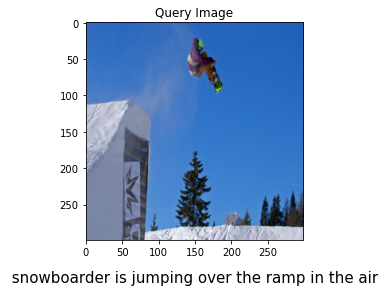

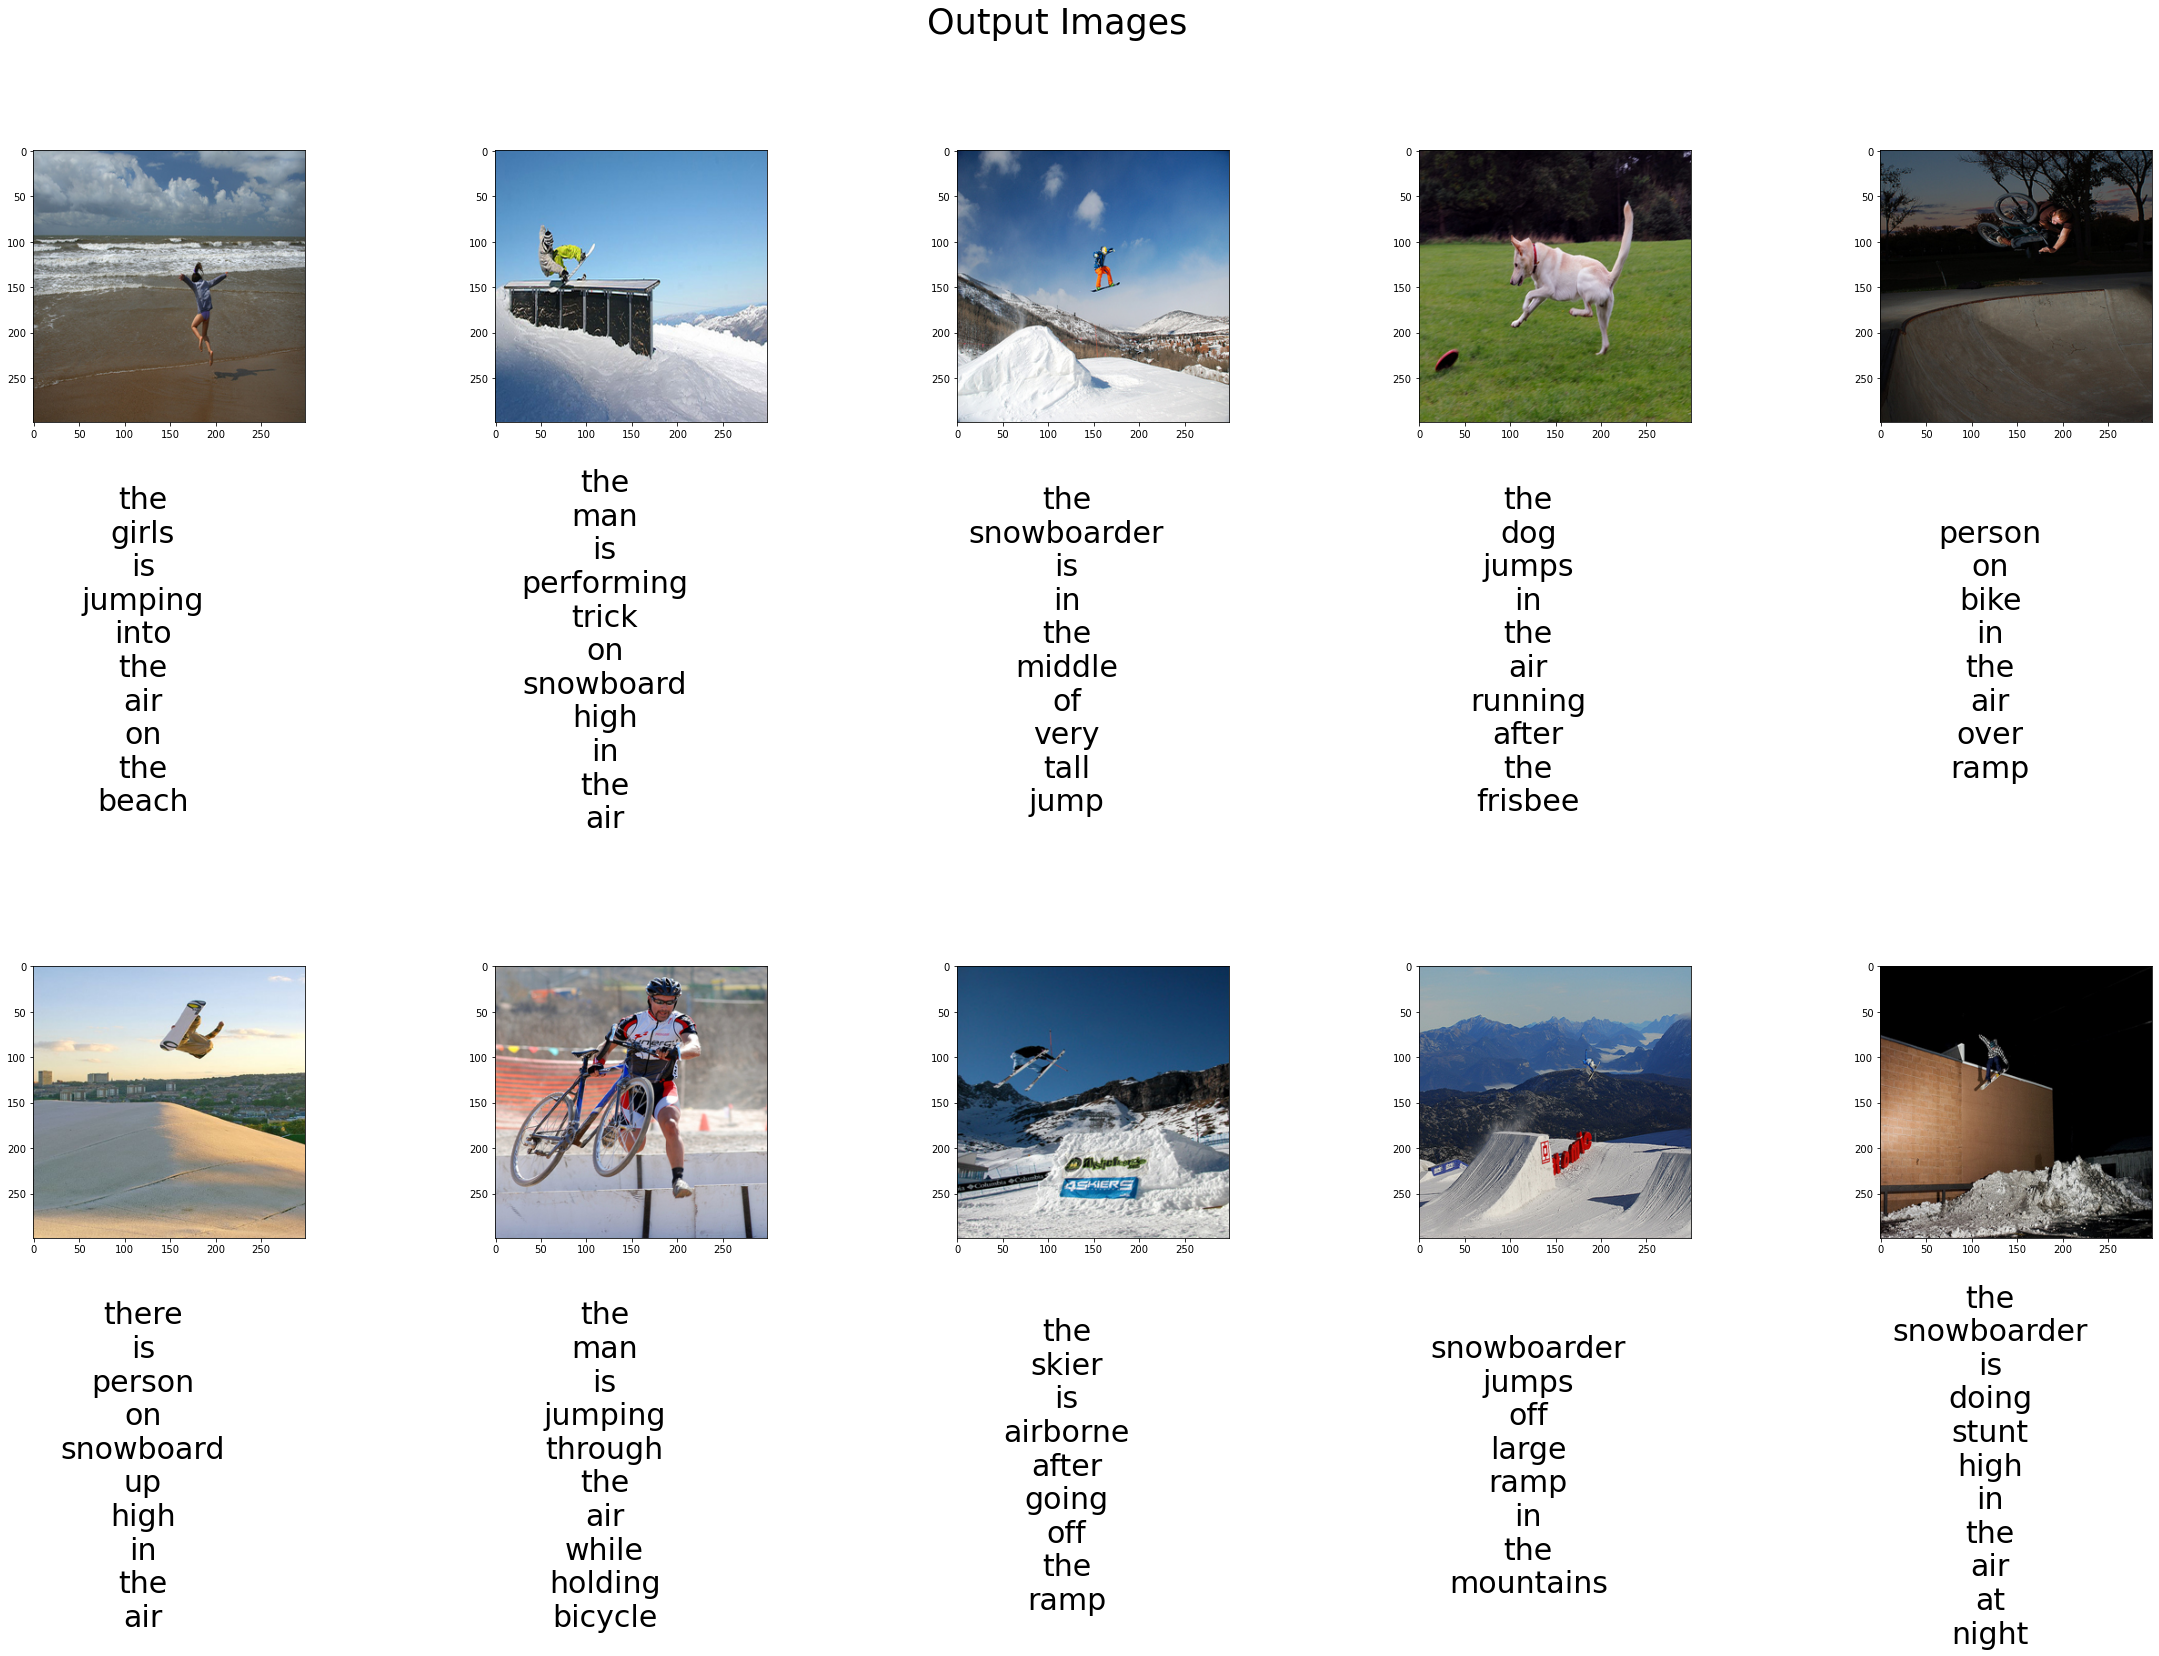

In [8]:
#Visualisation
img = Image.open(image_file)
img = img.resize((299,299))
plt.title("Query Image")
plt.text(150, 350, caption, horizontalalignment='center',verticalalignment='center',fontsize=15)
plt.imshow(img)
cols = 2
fig = plt.figure(figsize=(4, 2))
fig.suptitle("Output Images",fontsize=35)
for no,image in enumerate(final_Result.items()): # selecting top 10 images
    a = fig.add_subplot(cols, np.ceil(len(final_Result)/float(cols)), no + 1)
    plt.subplots_adjust(hspace = 2)
    img = Image.open("Data/Flicker8k_Dataset/"+image[0])
    img = img.resize((299,299))
    temp = image[1].split()
    temp = "\n".join(temp)
    a.text(120, 550, temp, horizontalalignment='center',verticalalignment='center',fontsize=30)
    plt.imshow(img)
fig.set_size_inches(np.array(fig.get_size_inches()) * len(final_Result))
plt.show()

Out of 10 images, 6 images are very similar to the generated caption, but 4 images are wrong prediction. i.e. 6/10. This is because the model is trained only on 12,000 images. If we train the above model with atleast 80,000 images, then we will get much more better predictions. As an extension to this project, we could use coco dataset which contains almost 100,000 images to train our model.

### Visualisation of divergent images output

<ipython-input-14-18a3aafec9f1>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  a = fig.add_subplot(cols, np.ceil(len(final_Result_2)/float(cols)), no + 1)


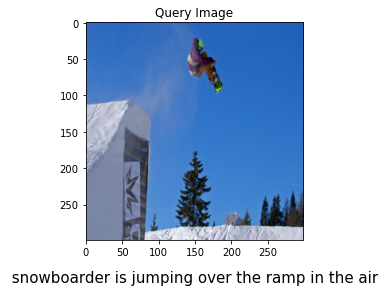

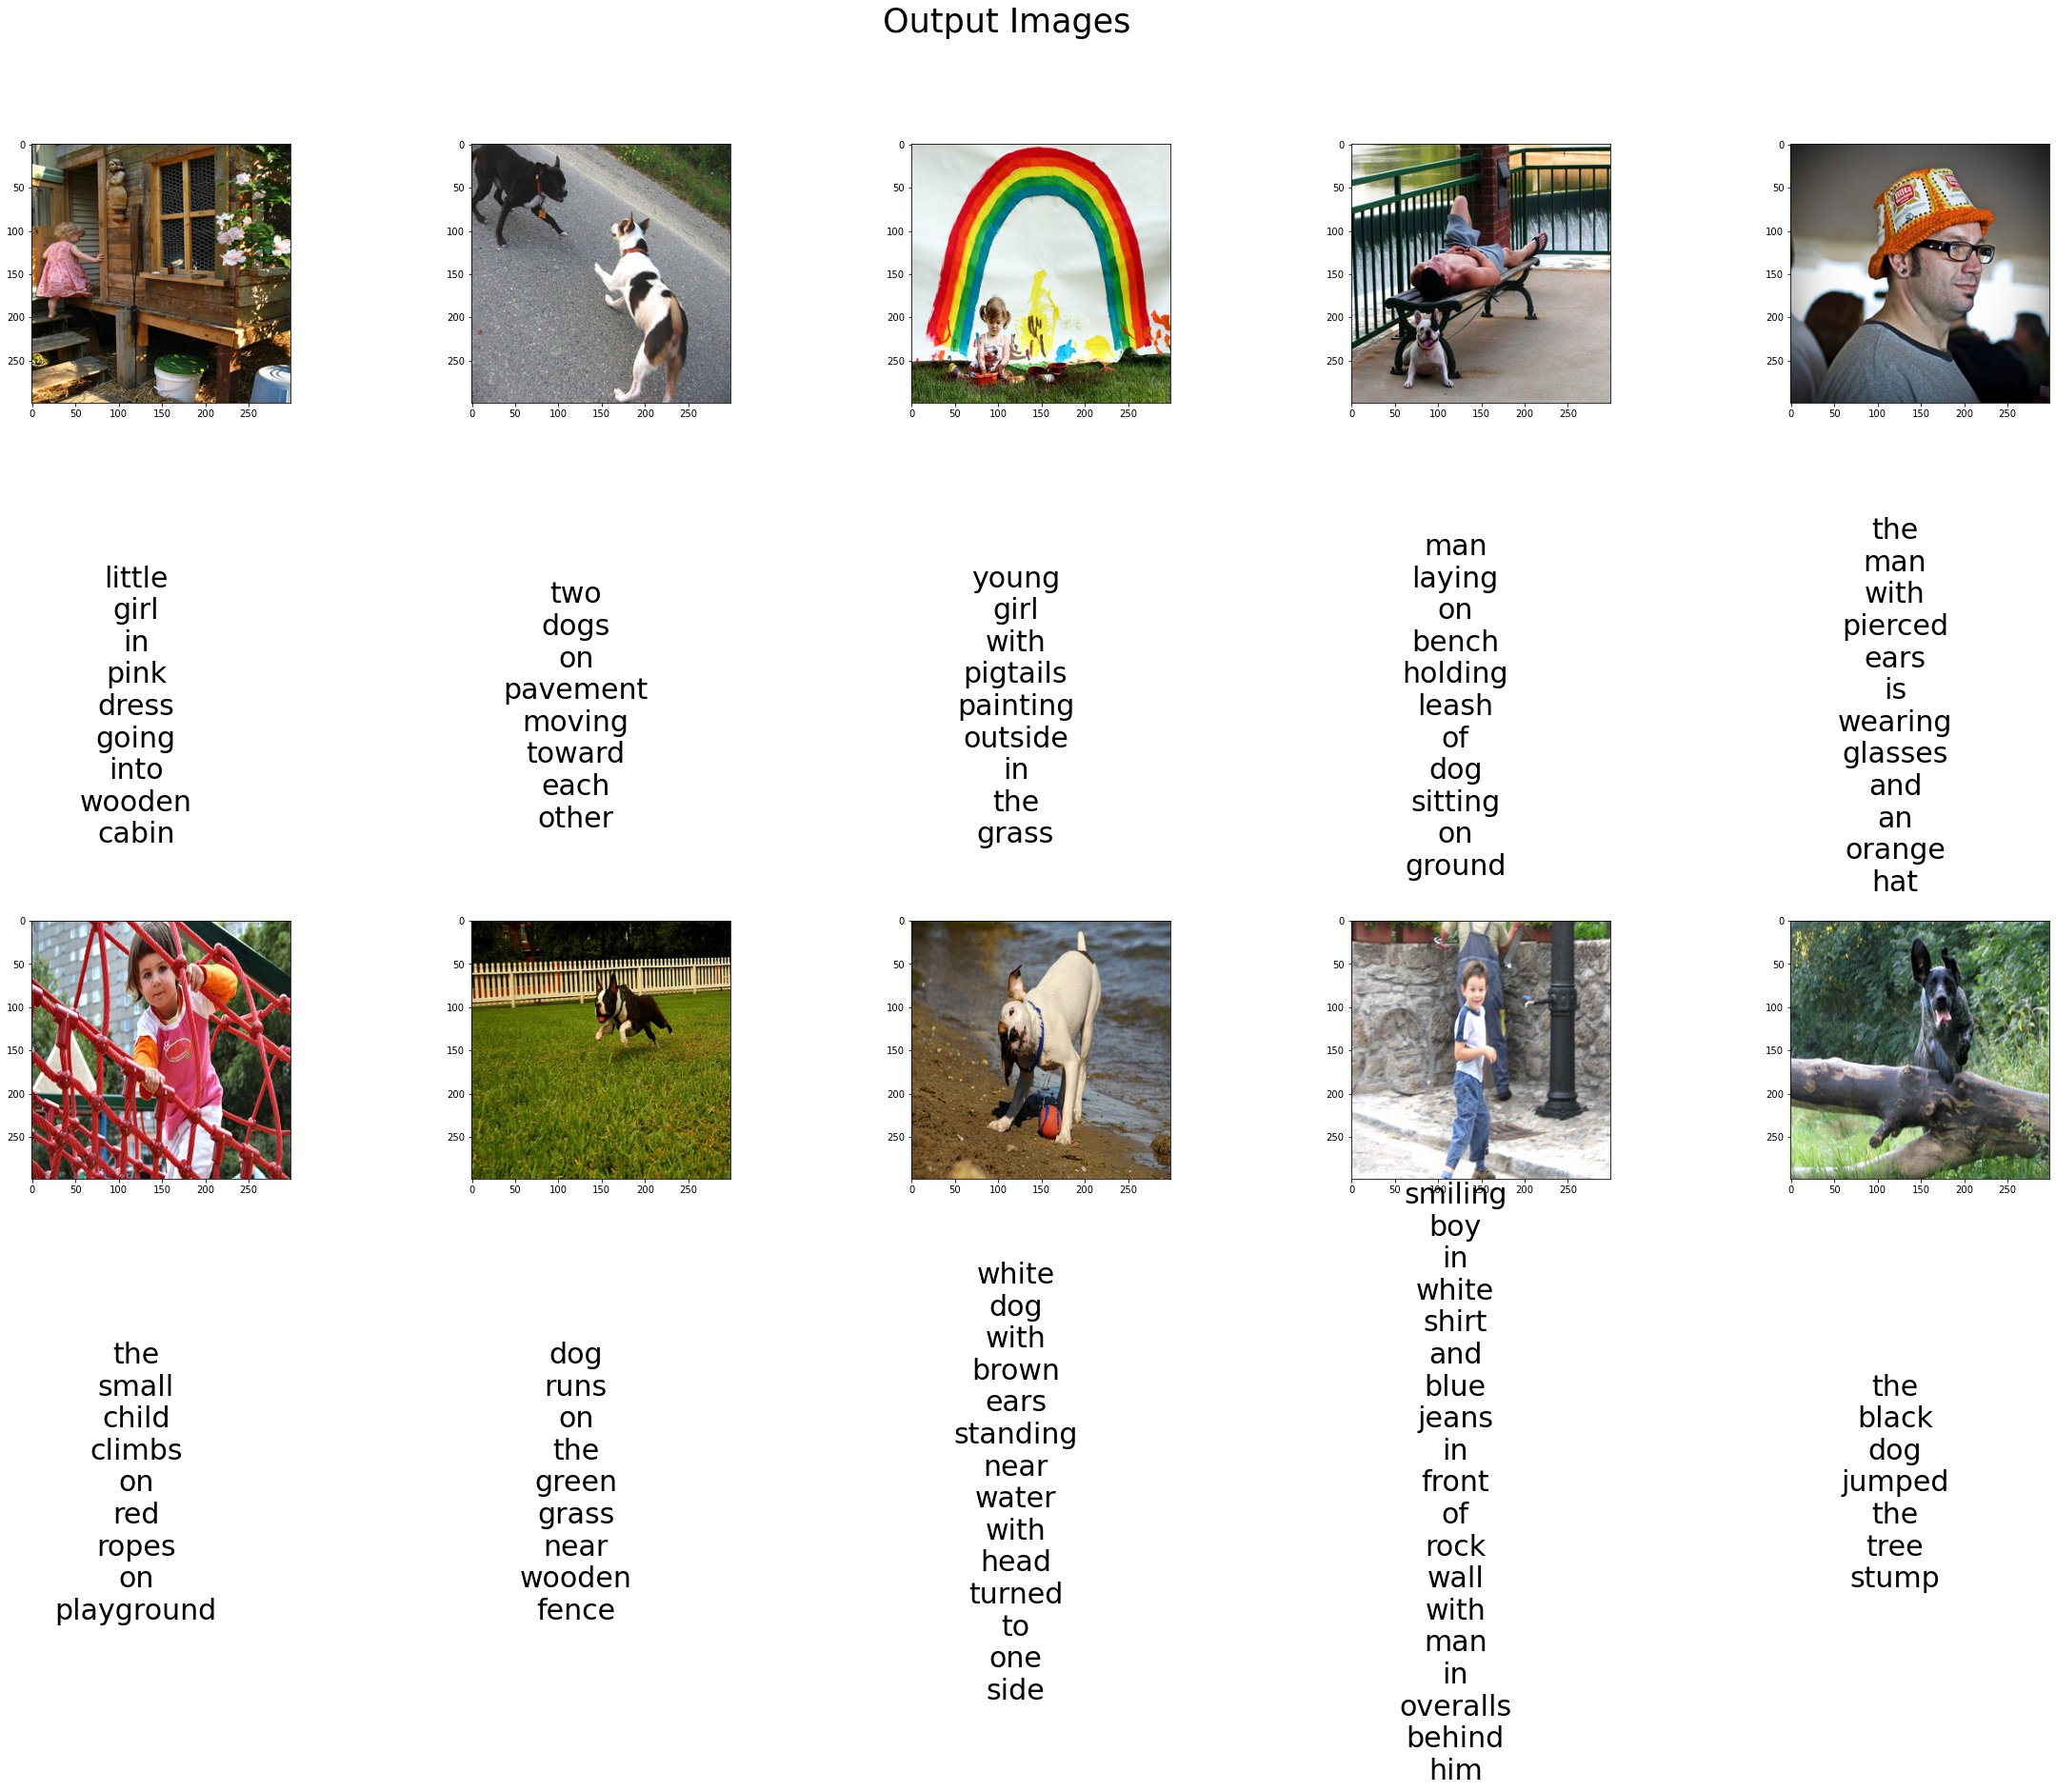

In [14]:
#Visualisation
img = Image.open(image_file)
img = img.resize((299,299))
plt.title("Query Image")
plt.text(150, 350, caption, horizontalalignment='center',verticalalignment='center',fontsize=15)
plt.imshow(img)
cols = 2
fig = plt.figure(figsize=(4, 2))
fig.suptitle("Output Images",fontsize=35)
for no,image in enumerate(final_Result_2.items()): # selecting top 10 images
    a = fig.add_subplot(cols, np.ceil(len(final_Result_2)/float(cols)), no + 1)
    plt.subplots_adjust(hspace = 2)
    img = Image.open("Data/Flicker8k_Dataset/"+image[0])
    img = img.resize((299,299))
    temp = image[1].split()
    temp = "\n".join(temp)
    a.text(120, 650, temp, horizontalalignment='center',verticalalignment='center',fontsize=30)
    plt.imshow(img)
fig.set_size_inches(np.array(fig.get_size_inches()) * len(final_Result_2))
plt.show()

In the above, output we can see dissimilar images given the threshold >=0.50 for text similarity, we get 10 dissimilar images for the given query image with captions.

### Evaluation

In [9]:
def evaluate_Divergent_Model(model,pretrained_model,max_length,path_To_Images,path_To_Images_Captions,
                             path_To_Images_Name,vocab,tokenized_text):
    actual_caption = []
    predicted_caption = []
    
    file1 = open(path_To_Images_Captions,"r")
    captions = file1.readlines()
    data = {lines.split("\t")[0].split("#")[0].strip("\'"):lines.split("\t")[1].rstrip().strip("\'") for lines in captions}
    
    #file2 = open(path_To_Images_Name,"r")
    #imageName = file2.readlines()
    #imageData = [imgName.split("\n")[0].rstrip().strip("\'") for imgName in imageName]
    
    for image,captions in data.items():
        #if(image in imageData):
        actual_caption.append(captions)
        generated_Caption = generate_Description(model,pretrained_model,max_length,path_To_Images+image,vocab,tokenized_text).split("start")[1].split("end")[0]
        predicted_caption.append(generated_Caption)
    
    print('BLEU-1: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual_caption, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25)))

In [10]:
evaluate_Divergent_Model(load_model('Models/Finalized_Model/model-ep003-loss3.414-val_loss3.621.h5'),
                         xception,max_length,"Data/Flicker8k_Dataset/","Data/Flickr8k_text/Captions.txt",
                         "Data/Flickr8k_text/Flickr_8k.testImages.txt",vocab,tokenized_text)

/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/lawrence/opt/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

BLEU-1: 0.316889
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
